In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (concatenate, Input, Dense, Dropout, BatchNormalization, 
                      Flatten, Conv1D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector)
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import Callback , LearningRateScheduler

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

#%matplotlib inline

In [2]:
path = '/datasets/'

Mounted at /content/drive


In [3]:
# Загружаем датасет
traff_df = pd.read_csv(path + '/traff.csv')
traff_df.head()

,1/1/2017,"22,226.00"
0,1/2/2017,"29,593.00"
1,1/3/2017,"31,726.00"
2,1/4/2017,"32,684.00"
3,1/5/2017,"31,820.00"
4,1/6/2017,"29,354.00"


In [4]:
# Информация о датасете
traff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1094 entries, 0 to 1093
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   1/1/2017   1094 non-null   object
 1   22,226.00  1094 non-null   object
dtypes: object(2)
memory usage: 17.2+ KB


In [5]:
# Названия колонок
traff_df.columns=['Date', 'Traff']

In [6]:
# Столбец Date в формат datetime. Столбец Traff d float
traff_df['Date'] = pd.to_datetime(traff_df['Date'])
traff_df['Traff'] = traff_df['Traff'].str.replace('.', '').str.replace(',', '.').astype(float)
traff_df.sample(3)

,Date,Traff
820,2019-04-02,20.839
309,2017-11-07,27.833
468,2018-04-15,19.257


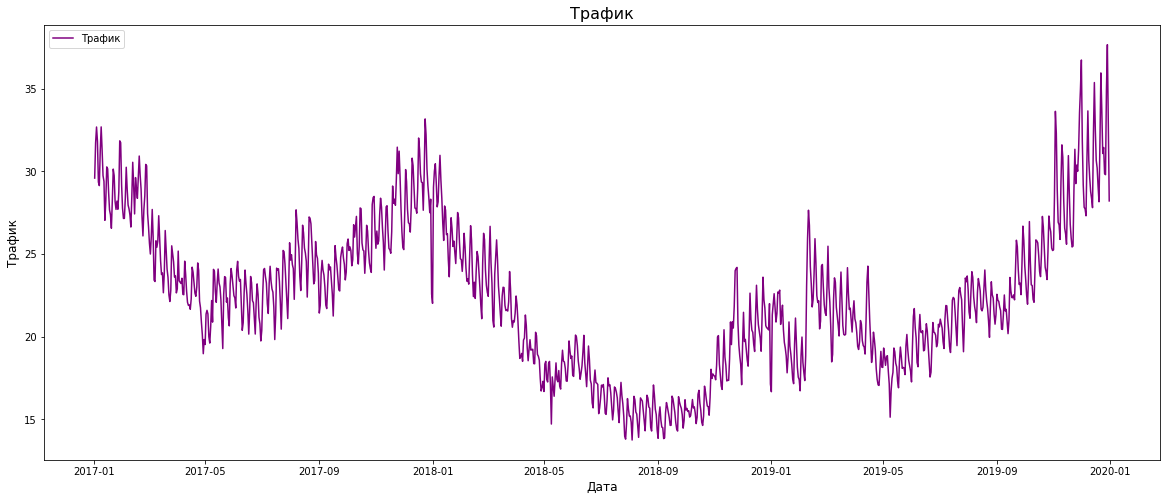

In [7]:
# График трафика
plt.figure(figsize=(20,8))

plt.plot(traff_df['Date'], traff_df['Traff'], label='Трафик', color='purple')
plt.title('Трафик', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Трафик', fontsize=12)
plt.legend()
plt.show()

In [8]:
# новый датасет с колонкой 'Traff'
traff = traff_df.drop('Date', axis=1)
traff.head()

,Traff
0,29.593
1,31.726
2,32.684
3,31.820
4,29.354


In [9]:
traff.shape

(1094, 1)

In [37]:
# Преобразовываем в массив numpy
traff_set = traff.values
len(traff_set), traff_set

(1094, array([[29.593],
        [31.726],
        [32.684],
        ...,
        [37.665],
        [32.643],
        [28.212]]))

In [11]:
X_len = 60
val_len = 280 # для проверки

traff_len = traff.shape[0] - val_len
traff_len

814

In [12]:
# Тренировочная и тетовая выборки
X_train, X_test = traff_set[:traff_len], traff_set[traff_len + X_len:]


In [13]:
# Масштабируем данные для X
X_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

In [14]:
# создаем y_train, y_test и делаем reshape
y_train, y_test = np.reshape(traff_set[:traff_len], (-1, 1)), np.reshape(traff_set[traff_len+X_len:], (-1, 1))

In [15]:
# Масштабируем данные для y
y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler.fit(y_train)
y_train = y_scaler.transform(y_train)
y_test = y_scaler.transform(y_test)

In [16]:
#Создаем генератор для обучения
trainDataGen = TimeseriesGenerator(X_train, y_train, length=X_len, stride=1, 
                                   sampling_rate=1, batch_size=10)

In [17]:
#Создаем генератор для валидации
valDataGen = TimeseriesGenerator(X_test, y_test, length=X_len, stride=1, 
                                   sampling_rate=1, batch_size=10)

In [18]:
len(X_test)

220

In [20]:
print(f' Обучющий генератор: {trainDataGen[0][0].shape} \n Валидационный генератор: {valDataGen[0][0].shape}')

 Обучющий генератор: (10, 60, 1) 
 Валидационный генератор: (10, 60, 1)


In [21]:
#Создадим генератор проверочной выборки
test_DataGen = TimeseriesGenerator(X_test, y_test, length=200, sampling_rate=1,
                                  batch_size=10)
X_val = []
y_val = []
for i in test_DataGen:
  X_val.append(i[0])
  y_val.append(i[1])

X_val = np.array(X_val)
y_val = np.array(y_val)

In [22]:
# Рассчитываем результаты прогнозирования сети
def getPred(curr_model, X_val, y_val, y_scaler):
    pred_val = y_scaler.inverse_transform(curr_model.predict(X_val))
    y_val_unscaled = y_scaler.inverse_transform(y_val)
  
    return (pred_val, y_val_unscaled)

In [23]:
# Визуализируем графики предсказанные сетью и правильные ответы
def showPredict(start, step, channel, pred_val, y_val_unscaled):
    plt.figure(figsize=(22,6))
    plt.plot(pred_val[start:start+step, 0], label='Прогноз')
    plt.plot(y_val_unscaled[start:start+step, channel], label='Реальное значение')
    plt.xlabel('Время', fontsize=12)
    plt.ylabel('Traff', fontsize=12)
    plt.legend()
    
    plt.show()

In [24]:
# Функция расёта корреляции двух одномерных векторов
def correlate(a, b):
    ma = a.mean()
    mb = b.mean()
    mab = (a * b).mean()
    sa = a.std()
    sb = b.std()
    #Рассчитываем корреляцию
    val = 1
    if ((sa > 0) & (sb > 0)):
        val = (mab - ma * mb) / (sa * sb)
    return val

In [26]:
# Проверяем появления эффекта автокорреляциикорреляции прогнозированного сигнала
def showCorr(channels, corr_steps, pred_val, y_val_unscaled):
    # Проходим по всем каналам
    for ch in channels:
        corr = []
        y_len = y_val_unscaled.shape[0]

      # Увеличикаем шаг, смещаем сигнал для проверки автокорреляции
        for i in range(corr_steps):
      # Рассчитываем их корреляцию и добавляем в лист
            corr.append(correlate(y_val_unscaled[:y_len - i, ch], pred_val[i:, 0]))

        own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i шагов обратно
    
    # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
        for i in range(corr_steps):
      # Рассчитываем их корреляцию и добавляем в лист
            own_corr.append(correlate(y_val_unscaled[:y_len - i, ch], y_val_unscaled[i:, ch]))
    # Отображаем график коррелций для данного шага
        plt.figure(figsize=(14,7))
        plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
        plt.plot(own_corr, label='Эталон')

    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    
    plt.show()

In [27]:
# Создаем нейронку LSTM
model = Sequential([
                    LSTM(32, return_sequences=True, input_shape=(X_len, 1)),
                    LSTM(16, return_sequences=False),
                    Dense(8, activation='relu'),
                    Dense(4, activation='relu'),
                    Flatten(),
                    Dense(1, activation='linear')
                    ])

In [28]:
model.compile(loss='mse', optimizer=Adam(lr=0.0001))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 32)            4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 36        
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 7,665
Trainable params: 7,665
Non-trainable params: 0
______________________________________________________

In [ ]:
'''def scheduler(epoch, current_learning_rate):
    if epoch == 20 :
        return current_learning_rate * 10
    else:
        return min(current_learning_rate, 0.0001)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)'''

In [30]:
history = model.fit(trainDataGen, epochs=100, validation_data=valDataGen, verbose=1)

Epoch 1/100
76/76 [==============================] - 6s 44ms/step - loss: 0.1837 - val_loss: 0.3498
Epoch 2/100
76/76 [==============================] - 3s 33ms/step - loss: 0.1305 - val_loss: 0.2078
Epoch 3/100
76/76 [==============================] - 2s 33ms/step - loss: 0.0418 - val_loss: 0.0733
Epoch 4/100
76/76 [==============================] - 3s 34ms/step - loss: 0.0225 - val_loss: 0.0639
Epoch 5/100
76/76 [==============================] - 3s 34ms/step - loss: 0.0169 - val_loss: 0.0530
Epoch 6/100
76/76 [==============================] - 3s 34ms/step - loss: 0.0146 - val_loss: 0.0486
Epoch 7/100
76/76 [==============================] - 3s 34ms/step - loss: 0.0132 - val_loss: 0.0439
Epoch 8/100
76/76 [==============================] - 3s 34ms/step - loss: 0.0126 - val_loss: 0.0414
Epoch 9/100
76/76 [==============================] - 3s 33ms/step - loss: 0.0118 - val_loss: 0.0380
Epoch 10/100
76/76 [==============================] - 3s 34ms/step - loss: 0.0112 - val_loss: 0.0335

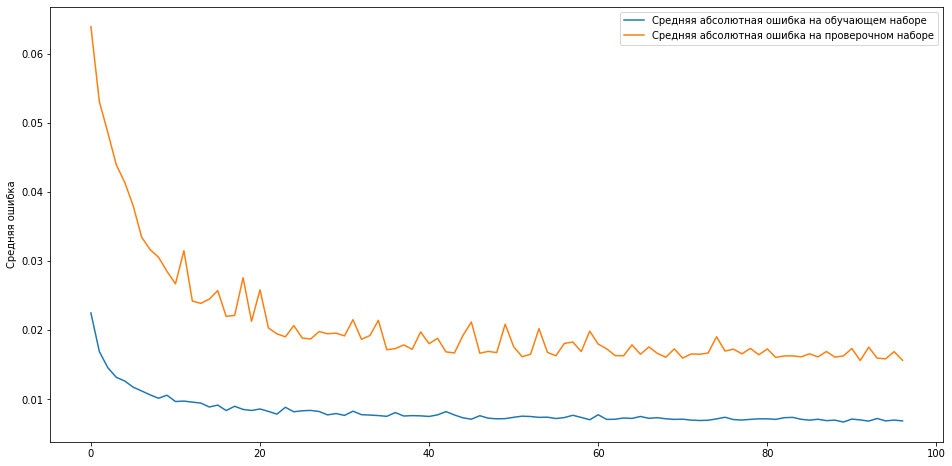

In [31]:
plt.figure(figsize=(16,8))
plt.plot(history.history['loss'][3:], label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'][3:], label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show() 

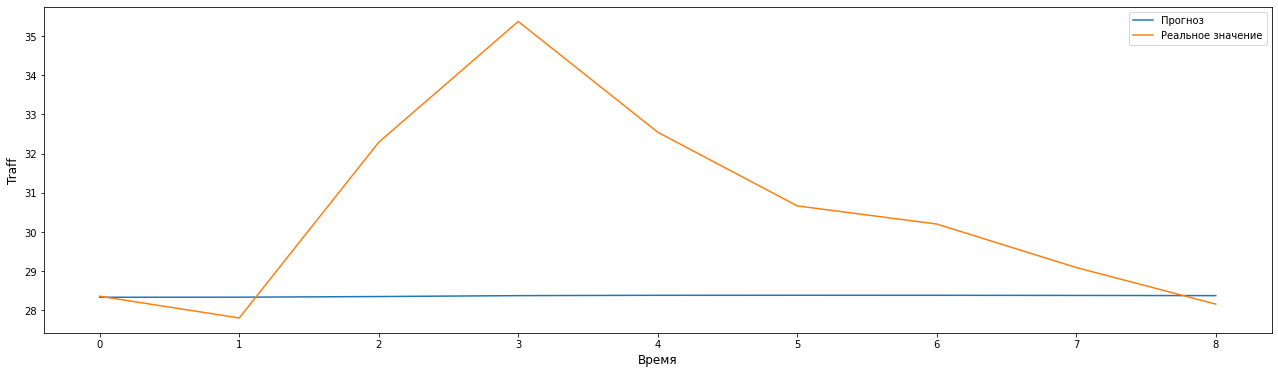

In [32]:
#Прогнозируем данные текущей сетью
curr_model = model
(pred_val, y_val_unscaled) = getPred(curr_model, X_val[0], y_val[0], y_scaler) #Прогнозируем данные
showPredict(0, 200, 0, pred_val[1:], y_val_unscaled[:-1])

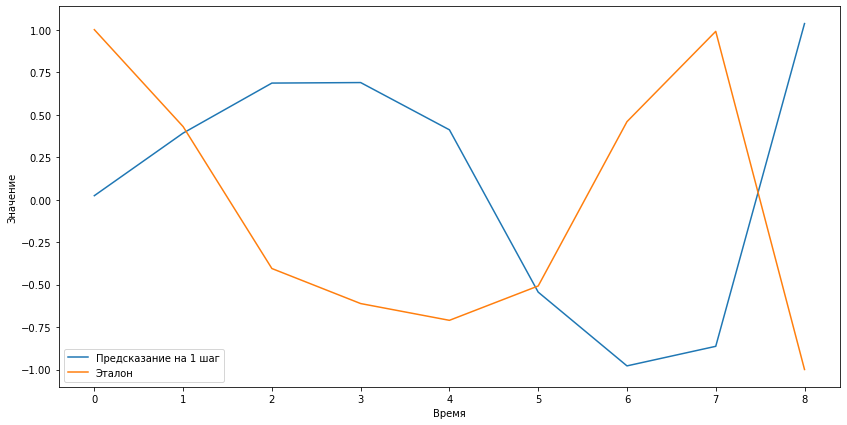

In [33]:
#Корреляциюя
showCorr([0], 9, pred_val, y_val_unscaled)

In [72]:
def get_corr_koef(level, data):    
    Xt = data # Возмем пример временного ряда
    Xt_1 = [0.0] * level + data[:-level] # Сдигаем на level шагов
    Xt = np.array(Xt[level:]) # Отбрасываем первые level-элементов и преобразуем в numpy
    Xt_1 = np.array(Xt_1[level:]) # Отбрасываем первые level-элементов и преобразуем в numpy 
    m1 = ((Xt[1:])*Xt_1).mean() # Считаем мат.ожидание от произведения двух временных рядов
    m2 = Xt.mean() # Считаем мат.ожидание первого временного ряда
    m3 = Xt_1.mean() # Считаем мат. ожидание второго временного ряда
    s1 = Xt.std() # Считаем ср.кв.отклонение первого временного ряда
    s2 = Xt_1.std() # Считаем ср.кв.отклонение второго временного ряда
    if s1!=0 and s2!=0:
        k1 = (m1 - m2 * m3 ) / (s1 * s2) # Считаем коэф.автокорреляции при смещении на level-шагов  
    else:
        k1=0
    return k1

print(f'Коэфициент= {get_corr_koef(1, traff_set):.4f}')

Коэфициент= 0.9423
Коэфициент=  0.9423
